In [1]:
# ================================================
# Cell 1: Install dependencies & Mount Drive (FIXED)
# ================================================

# Fix numpy compatibility issue first
!pip uninstall -y numpy
!pip install numpy==1.26.4

# Then install other dependencies
!pip -q install --upgrade "esm>=3.1.0" "torch>=2.1" biopython pandas tqdm matplotlib

# Restart might be needed after numpy change
print("✅ Dependencies installed")
print("⚠️ If you see numpy errors, click Runtime → Restart runtime, then run Cell 2")

from google.colab import drive
drive.mount('/content/drive')

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9",

✅ Dependencies installed
⚠️ If you see numpy errors, click Runtime → Restart runtime, then run Cell 2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ================================================
# Cell 2: Import libraries
# ================================================
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported")

✅ Libraries imported


In [3]:
# ================================================
# Cell 3: Configure paths
# ================================================
# Input files
PHASE1_OUTPUT = Path("/content/drive/MyDrive/PET2025/playground/mutation_scores/mutation_scores_full.csv")
WT_CSV = Path("/content/drive/MyDrive/PET2025/playground/data/pet-2025-wildtype-cds.csv")

# Output directory
OUTPUT_DIR = Path("/content/drive/MyDrive/PET2025/playground/structure_features")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

STRUCTURE_DIR = OUTPUT_DIR / "pdb_structures"
STRUCTURE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Phase 1 output: {PHASE1_OUTPUT}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Structure directory: {STRUCTURE_DIR}")

Phase 1 output: /content/drive/MyDrive/PET2025/playground/mutation_scores/mutation_scores_full.csv
Output directory: /content/drive/MyDrive/PET2025/playground/structure_features
Structure directory: /content/drive/MyDrive/PET2025/playground/structure_features/pdb_structures


In [4]:
# ================================================
# Cell 4: Load Phase 1 results
# ================================================
phase1_df = pd.read_csv(PHASE1_OUTPUT)
wt_df = pd.read_csv(WT_CSV)

print(f"Phase 1 sequences: {len(phase1_df)}")
print(f"Wild-type sequences: {len(wt_df)}")
print(f"Unique parent wild-types: {phase1_df['parent_wt'].nunique()}")

# Get unique wild-types that need structure prediction
unique_wts = phase1_df['parent_wt'].dropna().unique()
print(f"\nWild-types to predict structures for: {len(unique_wts)}")

Phase 1 sequences: 4988
Wild-type sequences: 313
Unique parent wild-types: 313

Wild-types to predict structures for: 313


In [5]:
# ================================================
# Cell 5: Connect to ESM3 Forge API for structure prediction
# ================================================
from getpass import getpass

token = getpass("🔑 Enter your Forge API Token: ")

from esm.sdk import client as esm_client
from esm.sdk.api import ESMProtein, GenerationConfig

# 4KmDJvB1gQaRJJDrWoBa91
# Connect to model
model = esm_client(
    model="esm3-open",
    url="https://forge.evolutionaryscale.ai",
    token=token
)

print("✅ Connected to ESM3 Forge API")

🔑 Enter your Forge API Token: ··········
✅ Connected to ESM3 Forge API


In [6]:
# ================================================
# Cell 6: Define catalytic residue positions for PETase
# ================================================
"""
PETase Catalytic Triad:
- The catalytic mechanism involves Ser-His-Asp triad
- These positions vary slightly between different PETase variants
- We'll identify them by conserved motifs

Reference IsPETase (most studied):
- Ser160 (nucleophile)
- Asp206 (stabilizes His)
- His237 (general base)

For other variants, we need to align and find corresponding positions.
"""

# Conserved motifs to identify catalytic residues
# These patterns help locate the catalytic triad in different PETases

def find_catalytic_positions(sequence):
    """
    Find catalytic triad positions in a PETase sequence.

    Uses conserved sequence patterns around catalytic residues.
    Returns dict with Ser, His, Asp positions (0-indexed).
    """

    # Method 1: Look for conserved GXSXG motif (serine hydrolase motif)
    # The catalytic Ser is in this motif
    ser_pos = None
    for i in range(len(sequence) - 5):
        if sequence[i] == 'G' and sequence[i+2] == 'S' and sequence[i+4] == 'G':
            # Found GXSXG motif
            ser_pos = i + 2
            break

    # Method 2: Look for the His in conserved context
    # Usually ~70-80 residues after Ser
    his_pos = None
    if ser_pos:
        search_start = ser_pos + 50
        search_end = min(ser_pos + 100, len(sequence))
        for i in range(search_start, search_end):
            if sequence[i] == 'H':
                # Check if it's in a reasonable context
                his_pos = i
                break

    # Method 3: Look for Asp between Ser and His
    asp_pos = None
    if ser_pos and his_pos:
        search_start = ser_pos + 30
        search_end = his_pos
        for i in range(search_start, search_end):
            if sequence[i] == 'D':
                asp_pos = i
                break

    # Fallback: use typical relative positions if motif search fails
    if ser_pos is None:
        # Estimate based on typical PETase length and structure
        seq_len = len(sequence)
        ser_pos = int(seq_len * 0.55)  # ~55% into sequence
        his_pos = int(seq_len * 0.85)  # ~85% into sequence
        asp_pos = int(seq_len * 0.70)  # ~70% into sequence

    return {
        'Ser': ser_pos,
        'His': his_pos,
        'Asp': asp_pos
    }

# Test on first wild-type
test_wt = unique_wts[0]
test_catalytic = find_catalytic_positions(test_wt)
print(f"Test wild-type length: {len(test_wt)}")
print(f"Catalytic positions found: {test_catalytic}")

Test wild-type length: 259
Catalytic positions found: {'Ser': 128, 'His': 182, 'Asp': 174}


In [7]:
# ================================================
# Cell 7: Structure prediction function using ESM3
# ================================================
import torch

def predict_structure_esm3(sequence, model):
    """
    Predict protein structure using ESM3 Forge API.

    Returns:
        tuple: (coordinates, plddt_scores) or (None, None) if failed
        - coordinates: numpy array of shape (L, 3) for Cα atoms
        - plddt_scores: numpy array of shape (L,) confidence scores
    """
    try:
        # Create protein object
        protein = ESMProtein(sequence=sequence)

        # Generate structure
        # ESM3 can generate structure from sequence
        protein_with_structure = model.generate(
            protein,
            GenerationConfig(
                track="structure",
                num_steps=8,  # More steps = better quality
                temperature=0.7
            )
        )

        # Extract coordinates
        if hasattr(protein_with_structure, 'coordinates') and protein_with_structure.coordinates is not None:
            coords = protein_with_structure.coordinates
            if isinstance(coords, torch.Tensor):
                coords = coords.detach().cpu().numpy()

            # Get pLDDT if available
            plddt = None
            if hasattr(protein_with_structure, 'plddt'):
                plddt = protein_with_structure.plddt
                if isinstance(plddt, torch.Tensor):
                    plddt = plddt.detach().cpu().numpy()

            return coords, plddt

        return None, None

    except Exception as e:
        print(f"Structure prediction error: {e}")
        return None, None

In [8]:
# ================================================
# Cell 8: Alternative - Use precomputed distance estimates
# ================================================
"""
If structure prediction is slow or unavailable, we can use
sequence-based estimates of distance to active site.

Key insight: In most PETases, the structure is conserved.
We can estimate distances based on sequence position relative
to catalytic residues.
"""

def estimate_distance_from_sequence(mutation_pos, catalytic_positions, seq_length):
    """
    Estimate distance to active site based on sequence position.

    This is a simplified estimate when actual structures aren't available.
    Based on typical PETase fold where:
    - Positions close in sequence to catalytic residues are likely close in 3D
    - Average protein has ~3.8Å per residue along backbone
    - But 3D distance is usually less due to protein folding

    Returns estimated distance in Angstroms.
    """

    ser_pos = catalytic_positions['Ser']
    his_pos = catalytic_positions['His']
    asp_pos = catalytic_positions['Asp']

    # Sequence distance to each catalytic residue
    seq_dist_ser = abs(mutation_pos - ser_pos)
    seq_dist_his = abs(mutation_pos - his_pos)
    seq_dist_asp = abs(mutation_pos - asp_pos)

    min_seq_dist = min(seq_dist_ser, seq_dist_his, seq_dist_asp)

    # Convert sequence distance to approximate 3D distance
    # Empirical formula based on protein structure statistics
    # Close in sequence (< 10 residues): fairly accurate linear estimate
    # Far in sequence: 3D distance plateaus due to globular fold

    if min_seq_dist <= 5:
        estimated_3d_dist = min_seq_dist * 3.0  # ~3Å per residue for close contacts
    elif min_seq_dist <= 15:
        estimated_3d_dist = 15 + (min_seq_dist - 5) * 1.5  # Slower increase
    elif min_seq_dist <= 30:
        estimated_3d_dist = 30 + (min_seq_dist - 15) * 0.8
    else:
        # Far in sequence - could be close or far in 3D
        # Assume moderate distance for globular protein
        estimated_3d_dist = min(40 + (min_seq_dist - 30) * 0.3, 60)

    return estimated_3d_dist, min_seq_dist

In [9]:
# ================================================
# Cell 9: Compute structure features for all mutations
# ================================================

def compute_structure_features_fast(phase1_df, use_structure_prediction=False):
    """
    Compute structure-based features for all mutations.

    Fast version uses sequence-based estimates.
    Set use_structure_prediction=True to use ESM3 (slower but more accurate).
    """

    results = []

    # Cache catalytic positions for each wild-type
    wt_catalytic_cache = {}

    for idx, row in tqdm(phase1_df.iterrows(), total=len(phase1_df)):
        seq = row['sequence']
        is_wt = row['is_wildtype']
        parent_wt = row['parent_wt']
        mut_pos = row['mutation_position']

        # Get or compute catalytic positions for this wild-type
        if parent_wt not in wt_catalytic_cache:
            wt_catalytic_cache[parent_wt] = find_catalytic_positions(parent_wt)

        catalytic_pos = wt_catalytic_cache[parent_wt]

        if is_wt or pd.isna(mut_pos):
            # Wild-type: no mutation position
            results.append({
                'index': row['index'],
                'sequence': seq,
                'is_wildtype': is_wt,
                'catalytic_ser': catalytic_pos['Ser'],
                'catalytic_his': catalytic_pos['His'],
                'catalytic_asp': catalytic_pos['Asp'],
                'mutation_position': None,
                'dist_to_active_site': 0,  # WT is the reference
                'seq_dist_to_catalytic': 0,
                'position_relative': None,
                'near_active_site': False
            })
        else:
            mut_pos = int(mut_pos)

            # Estimate distance to active site
            est_dist, seq_dist = estimate_distance_from_sequence(
                mut_pos, catalytic_pos, len(seq)
            )

            # Determine relative position
            ser_pos = catalytic_pos['Ser']
            if mut_pos < ser_pos - 20:
                position_rel = 'N-terminal'
            elif mut_pos > catalytic_pos['His'] + 20:
                position_rel = 'C-terminal'
            else:
                position_rel = 'core'

            # Is mutation near active site?
            near_active = seq_dist <= 10

            results.append({
                'index': row['index'],
                'sequence': seq,
                'is_wildtype': is_wt,
                'catalytic_ser': catalytic_pos['Ser'],
                'catalytic_his': catalytic_pos['His'],
                'catalytic_asp': catalytic_pos['Asp'],
                'mutation_position': mut_pos,
                'dist_to_active_site': est_dist,
                'seq_dist_to_catalytic': seq_dist,
                'position_relative': position_rel,
                'near_active_site': near_active
            })

    return pd.DataFrame(results)

# Run fast version
print("Computing structure features (sequence-based estimates)...")
structure_df = compute_structure_features_fast(phase1_df, use_structure_prediction=False)
print(f"✅ Computed features for {len(structure_df)} sequences")

Computing structure features (sequence-based estimates)...


100%|██████████| 4988/4988 [00:01<00:00, 4281.40it/s]


✅ Computed features for 4988 sequences


In [10]:
# ================================================
# Cell 10: Add secondary structure predictions
# ================================================
"""
Secondary structure prediction based on sequence patterns.
This is a simplified approach - for more accuracy, use DSSP on predicted structures.
"""

def predict_secondary_structure_simple(sequence, position):
    """
    Simple secondary structure prediction based on local sequence.

    Uses propensity scales for helix/sheet/coil.
    """

    # Amino acid propensities (Chou-Fasman parameters, simplified)
    helix_propensity = {
        'A': 1.42, 'E': 1.51, 'L': 1.21, 'M': 1.45, 'Q': 1.11,
        'K': 1.16, 'R': 0.98, 'H': 1.00, 'V': 1.06, 'I': 1.08,
        'Y': 0.69, 'C': 0.70, 'W': 1.08, 'F': 1.13, 'T': 0.83,
        'G': 0.57, 'N': 0.67, 'P': 0.57, 'S': 0.77, 'D': 1.01
    }

    sheet_propensity = {
        'V': 1.70, 'I': 1.60, 'Y': 1.47, 'F': 1.38, 'W': 1.37,
        'L': 1.30, 'T': 1.19, 'C': 1.19, 'M': 1.05, 'A': 0.83,
        'R': 0.93, 'G': 0.75, 'D': 0.54, 'K': 0.74, 'S': 0.75,
        'H': 0.87, 'N': 0.89, 'Q': 1.10, 'P': 0.55, 'E': 0.37
    }

    # Get local window (±4 residues)
    window_size = 4
    start = max(0, position - window_size)
    end = min(len(sequence), position + window_size + 1)
    local_seq = sequence[start:end]

    # Calculate average propensities
    helix_score = np.mean([helix_propensity.get(aa, 1.0) for aa in local_seq])
    sheet_score = np.mean([sheet_propensity.get(aa, 1.0) for aa in local_seq])

    # Predict structure type
    if helix_score > 1.1 and helix_score > sheet_score:
        return 'helix', helix_score
    elif sheet_score > 1.1 and sheet_score > helix_score:
        return 'sheet', sheet_score
    else:
        return 'coil', max(helix_score, sheet_score)

# Add secondary structure predictions
print("\nPredicting secondary structure...")
ss_predictions = []
ss_scores = []

for idx, row in tqdm(structure_df.iterrows(), total=len(structure_df)):
    if row['is_wildtype'] or pd.isna(row['mutation_position']):
        ss_predictions.append('N/A')
        ss_scores.append(0)
    else:
        ss, score = predict_secondary_structure_simple(
            row['sequence'],
            int(row['mutation_position'])
        )
        ss_predictions.append(ss)
        ss_scores.append(score)

structure_df['secondary_structure'] = ss_predictions
structure_df['ss_propensity_score'] = ss_scores

print("✅ Secondary structure predictions added")


Predicting secondary structure...


100%|██████████| 4988/4988 [00:00<00:00, 5556.59it/s]


✅ Secondary structure predictions added


In [11]:
# ================================================
# Cell 11: Add burial/exposure estimation
# ================================================
"""
Estimate whether a position is buried or exposed based on:
1. Local hydrophobicity
2. Position relative to termini
3. Amino acid type
"""

def estimate_burial(sequence, position, wt_aa):
    """
    Estimate if a position is buried or exposed.

    Returns: 'buried', 'partial', or 'exposed'
    """

    # Hydrophobicity scale
    hydrophobicity = {
        'I': 4.5, 'V': 4.2, 'L': 3.8, 'F': 2.8, 'C': 2.5,
        'M': 1.9, 'A': 1.8, 'G': -0.4, 'T': -0.7, 'S': -0.8,
        'W': -0.9, 'Y': -1.3, 'P': -1.6, 'H': -3.2, 'E': -3.5,
        'Q': -3.5, 'D': -3.5, 'N': -3.5, 'K': -3.9, 'R': -4.5
    }

    # Get local hydrophobicity (±5 residues)
    window = 5
    start = max(0, position - window)
    end = min(len(sequence), position + window + 1)
    local_seq = sequence[start:end]

    local_hydro = np.mean([hydrophobicity.get(aa, 0) for aa in local_seq])
    aa_hydro = hydrophobicity.get(wt_aa, 0)

    # Check if near terminus (usually more exposed)
    near_terminus = position < 15 or position > len(sequence) - 15

    # Decision logic
    if near_terminus:
        return 'exposed'
    elif local_hydro > 2.0 and aa_hydro > 2.0:
        return 'buried'
    elif local_hydro > 0.5 or aa_hydro > 1.0:
        return 'partial'
    else:
        return 'exposed'

print("\nEstimating burial/exposure...")
burial_estimates = []

for idx, row in tqdm(structure_df.iterrows(), total=len(structure_df)):
    if row['is_wildtype'] or pd.isna(row['mutation_position']):
        burial_estimates.append('N/A')
    else:
        # Get wt_aa from phase1_df
        wt_aa = phase1_df.loc[phase1_df['index'] == row['index'], 'wt_aa'].values
        if len(wt_aa) > 0 and pd.notna(wt_aa[0]):
            burial = estimate_burial(
                row['sequence'],
                int(row['mutation_position']),
                wt_aa[0]
            )
            burial_estimates.append(burial)
        else:
            burial_estimates.append('unknown')

structure_df['burial_status'] = burial_estimates

print("✅ Burial estimation added")


Estimating burial/exposure...


100%|██████████| 4988/4988 [00:03<00:00, 1301.20it/s]

✅ Burial estimation added


In [12]:
# ================================================
# Cell 12: Compute structure risk score
# ================================================
"""
Combine all structure features into a single risk score.

Higher risk = mutation more likely to affect activity
"""

def compute_structure_risk_score(row):
    """
    Compute overall structure-based risk score.

    Returns: float between 0 (low risk) and 1 (high risk)
    """

    if row['is_wildtype']:
        return 0.0

    risk = 0.0

    # 1. Distance to active site (closer = higher risk)
    dist = row['dist_to_active_site']
    if dist < 10:
        risk += 0.4  # Very close - high risk
    elif dist < 20:
        risk += 0.25
    elif dist < 30:
        risk += 0.1
    # else: low risk from distance

    # 2. Near active site flag
    if row['near_active_site']:
        risk += 0.2

    # 3. Secondary structure context
    ss = row['secondary_structure']
    if ss == 'helix':
        risk += 0.1  # Helix mutations can disrupt structure
    elif ss == 'sheet':
        risk += 0.1  # Sheet mutations can disrupt packing
    # Coil is more tolerant

    # 4. Burial status
    burial = row['burial_status']
    if burial == 'buried':
        risk += 0.15  # Buried mutations are riskier
    elif burial == 'partial':
        risk += 0.05
    # Exposed is more tolerant

    # 5. Core region
    if row['position_relative'] == 'core':
        risk += 0.1

    # Normalize to 0-1
    return min(risk, 1.0)

print("\nComputing structure risk scores...")
structure_df['structure_risk_score'] = structure_df.apply(compute_structure_risk_score, axis=1)

print("✅ Structure risk scores computed")


Computing structure risk scores...
✅ Structure risk scores computed


In [13]:
# ================================================
# Cell 13: Merge with Phase 1 results
# ================================================
# Select columns to merge
structure_features = structure_df[[
    'index',
    'catalytic_ser', 'catalytic_his', 'catalytic_asp',
    'dist_to_active_site', 'seq_dist_to_catalytic',
    'position_relative', 'near_active_site',
    'secondary_structure', 'ss_propensity_score',
    'burial_status', 'structure_risk_score'
]]

# Merge with Phase 1 results
combined_df = phase1_df.merge(structure_features, on='index', how='left')

print(f"Combined dataframe shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")

Combined dataframe shape: (4988, 20)
Columns: ['index', 'sequence', 'is_wildtype', 'parent_wt', 'mutation_position', 'wt_aa', 'mut_aa', 'mutation_llr', 'pseudo_likelihood', 'catalytic_ser', 'catalytic_his', 'catalytic_asp', 'dist_to_active_site', 'seq_dist_to_catalytic', 'position_relative', 'near_active_site', 'secondary_structure', 'ss_propensity_score', 'burial_status', 'structure_risk_score']


In [14]:
# ================================================
# Cell 14: Save Phase 2 results
# ================================================
# Save structure features only
STRUCTURE_OUTPUT = OUTPUT_DIR / "structure_features.csv"
structure_df.to_csv(STRUCTURE_OUTPUT, index=False)
print(f"✅ Structure features saved to {STRUCTURE_OUTPUT}")

# Save combined Phase 1 + Phase 2 results
COMBINED_OUTPUT = OUTPUT_DIR / "phase1_phase2_combined.csv"
combined_df.to_csv(COMBINED_OUTPUT, index=False)
print(f"✅ Combined results saved to {COMBINED_OUTPUT}")

✅ Structure features saved to /content/drive/MyDrive/PET2025/playground/structure_features/structure_features.csv
✅ Combined results saved to /content/drive/MyDrive/PET2025/playground/structure_features/phase1_phase2_combined.csv


In [15]:
# ================================================
# Cell 15: Analyze results
# ================================================
print("\n" + "=" * 60)
print("PHASE 2 RESULTS SUMMARY")
print("=" * 60)

# Mutation statistics
mutants = combined_df[~combined_df['is_wildtype']]

print(f"\nTotal mutants analyzed: {len(mutants)}")

print("\n--- Distance to Active Site ---")
print(f"Mean distance: {mutants['dist_to_active_site'].mean():.2f} Å")
print(f"Min distance:  {mutants['dist_to_active_site'].min():.2f} Å")
print(f"Max distance:  {mutants['dist_to_active_site'].max():.2f} Å")

print(f"\nMutations near active site (≤10 residues): {mutants['near_active_site'].sum()}")
print(f"Percentage: {mutants['near_active_site'].mean()*100:.1f}%")

print("\n--- Secondary Structure Distribution ---")
print(mutants['secondary_structure'].value_counts())

print("\n--- Burial Status Distribution ---")
print(mutants['burial_status'].value_counts())

print("\n--- Position Relative to Core ---")
print(mutants['position_relative'].value_counts())

print("\n--- Structure Risk Score ---")
print(f"Mean risk score: {mutants['structure_risk_score'].mean():.3f}")
print(f"High risk (>0.5): {(mutants['structure_risk_score'] > 0.5).sum()}")
print(f"Medium risk (0.3-0.5): {((mutants['structure_risk_score'] > 0.3) & (mutants['structure_risk_score'] <= 0.5)).sum()}")
print(f"Low risk (≤0.3): {(mutants['structure_risk_score'] <= 0.3).sum()}")


PHASE 2 RESULTS SUMMARY

Total mutants analyzed: 4674

--- Distance to Active Site ---
Mean distance: 34.50 Å
Min distance:  0.00 Å
Max distance:  60.00 Å

Mutations near active site (≤10 residues): 1273
Percentage: 27.2%

--- Secondary Structure Distribution ---
secondary_structure
coil     2994
sheet    1042
helix     638
Name: count, dtype: int64

--- Burial Status Distribution ---
burial_status
exposed    2395
partial    2267
buried       12
Name: count, dtype: int64

--- Position Relative to Core ---
position_relative
core          2242
N-terminal    1957
C-terminal     475
Name: count, dtype: int64

--- Structure Risk Score ---
Mean risk score: 0.253
High risk (>0.5): 1225
Medium risk (0.3-0.5): 178
Low risk (≤0.3): 3271


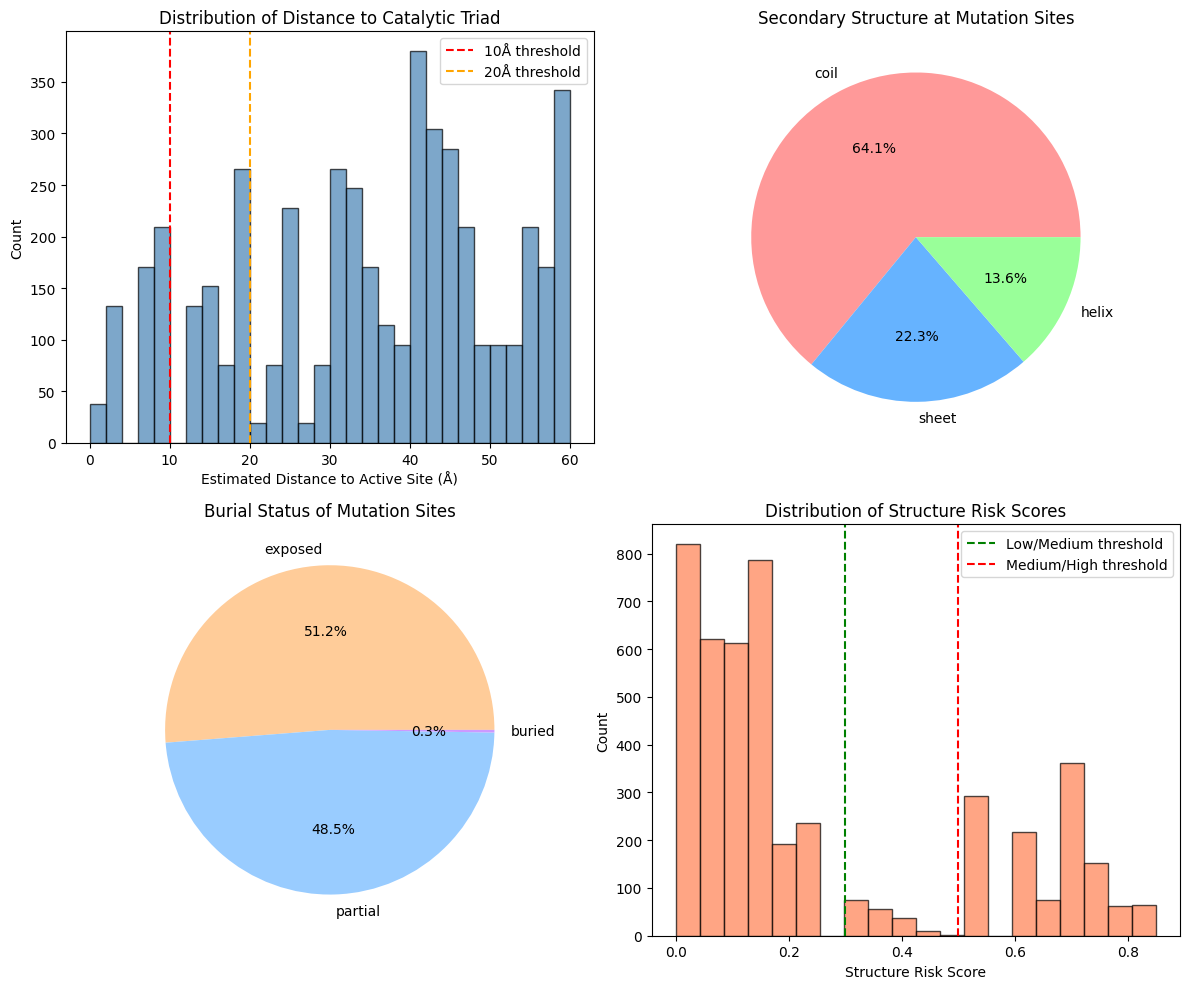


📊 Figure saved to /content/drive/MyDrive/PET2025/playground/structure_features/phase2_structure_analysis.png


In [16]:
# ================================================
# Cell 16: Visualize results
# ================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Distance to active site distribution
ax1 = axes[0, 0]
ax1.hist(mutants['dist_to_active_site'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=10, color='red', linestyle='--', label='10Å threshold')
ax1.axvline(x=20, color='orange', linestyle='--', label='20Å threshold')
ax1.set_xlabel('Estimated Distance to Active Site (Å)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Distance to Catalytic Triad')
ax1.legend()

# Plot 2: Secondary structure pie chart
ax2 = axes[0, 1]
ss_counts = mutants['secondary_structure'].value_counts()
ax2.pie(ss_counts.values, labels=ss_counts.index, autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff', '#99ff99'])
ax2.set_title('Secondary Structure at Mutation Sites')

# Plot 3: Burial status pie chart
ax3 = axes[1, 0]
burial_counts = mutants['burial_status'].value_counts()
ax3.pie(burial_counts.values, labels=burial_counts.index, autopct='%1.1f%%',
        colors=['#ffcc99', '#99ccff', '#cc99ff'])
ax3.set_title('Burial Status of Mutation Sites')

# Plot 4: Structure risk score distribution
ax4 = axes[1, 1]
ax4.hist(mutants['structure_risk_score'], bins=20, edgecolor='black', alpha=0.7, color='coral')
ax4.axvline(x=0.3, color='green', linestyle='--', label='Low/Medium threshold')
ax4.axvline(x=0.5, color='red', linestyle='--', label='Medium/High threshold')
ax4.set_xlabel('Structure Risk Score')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of Structure Risk Scores')
ax4.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'phase2_structure_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Figure saved to {OUTPUT_DIR / 'phase2_structure_analysis.png'}")

In [17]:
# ================================================
# Cell 17: Correlation between Phase 1 and Phase 2 features
# ================================================
print("\n" + "=" * 60)
print("PHASE 1 vs PHASE 2 CORRELATION ANALYSIS")
print("=" * 60)

# Correlation between mutation_llr and structure_risk_score
corr = mutants[['mutation_llr', 'structure_risk_score']].corr()
print(f"\nCorrelation (LLR vs Structure Risk): {corr.iloc[0,1]:.4f}")

# LLR by distance category
print("\n--- Mean LLR by Distance to Active Site ---")
mutants['dist_category'] = pd.cut(mutants['dist_to_active_site'],
                                   bins=[0, 15, 30, 45, 100],
                                   labels=['<15Å', '15-30Å', '30-45Å', '>45Å'])
print(mutants.groupby('dist_category')['mutation_llr'].agg(['mean', 'std', 'count']))

# LLR by burial status
print("\n--- Mean LLR by Burial Status ---")
print(mutants.groupby('burial_status')['mutation_llr'].agg(['mean', 'std', 'count']))

# LLR by secondary structure
print("\n--- Mean LLR by Secondary Structure ---")
print(mutants.groupby('secondary_structure')['mutation_llr'].agg(['mean', 'std', 'count']))


PHASE 1 vs PHASE 2 CORRELATION ANALYSIS

Correlation (LLR vs Structure Risk): -0.1532

--- Mean LLR by Distance to Active Site ---
                   mean       std  count
dist_category                           
<15Å          -2.804833  5.255998    798
15-30Å        -0.997579  4.033350    855
30-45Å        -0.414638  3.347474   1615
>45Å          -0.905621  3.859277   1368

--- Mean LLR by Burial Status ---
                   mean       std  count
burial_status                           
buried         1.482931  3.772605     12
exposed       -1.041138  4.095284   2395
partial       -1.092306  4.067158   2267

--- Mean LLR by Secondary Structure ---
                         mean       std  count
secondary_structure                           
coil                -1.265533  3.983926   2994
helix               -0.741557  3.872499    638
sheet               -0.662063  4.433190   1042


In [18]:
# ================================================
# Cell 18: Preview combined predictions
# ================================================
print("\n" + "=" * 60)
print("PREVIEW: Combined Phase 1 + Phase 2 Predictions")
print("=" * 60)

def predict_activity_phase1_phase2(row):
    """
    Predict activity using Phase 1 and Phase 2 features.
    """
    if row['is_wildtype']:
        return 1.0  # Baseline activity for wild-type

    # Phase 1: ESM3 evolutionary signal
    llr = row['mutation_llr']
    llr_score = 1 / (1 + np.exp(-llr))  # Sigmoid

    # Phase 2: Structure risk
    struct_risk = row['structure_risk_score']
    struct_score = 1 - struct_risk  # Invert so higher = better

    # Combined prediction
    # Weight: 60% evolutionary, 40% structural
    combined_score = 0.6 * llr_score + 0.4 * struct_score

    # Scale to activity range
    activity = combined_score * 1.5 + 0.1

    return activity

# Apply prediction
combined_df['predicted_activity_v2'] = combined_df.apply(predict_activity_phase1_phase2, axis=1)

# Compare with Phase 1 only prediction
print("\n--- Prediction Comparison ---")
print(f"Phase 1 only - Mean predicted activity: N/A (not in this file)")
print(f"Phase 1+2 - Mean predicted activity: {combined_df['predicted_activity_v2'].mean():.3f}")
print(f"Phase 1+2 - Std: {combined_df['predicted_activity_v2'].std():.3f}")
print(f"Phase 1+2 - Range: [{combined_df['predicted_activity_v2'].min():.3f}, {combined_df['predicted_activity_v2'].max():.3f}]")


PREVIEW: Combined Phase 1 + Phase 2 Predictions

--- Prediction Comparison ---
Phase 1 only - Mean predicted activity: N/A (not in this file)
Phase 1+2 - Mean predicted activity: 0.917
Phase 1+2 - Std: 0.371
Phase 1+2 - Range: [0.190, 1.600]


In [19]:
# ================================================
# Cell 19: Save final Phase 2 outputs
# ================================================
# Final combined file with all features and predictions
FINAL_OUTPUT = OUTPUT_DIR / "phase2_complete.csv"
combined_df.to_csv(FINAL_OUTPUT, index=False)
print(f"\n✅ Final Phase 2 results saved to {FINAL_OUTPUT}")

# Summary statistics file
summary = {
    'Total sequences': len(combined_df),
    'Wild-types': combined_df['is_wildtype'].sum(),
    'Mutants': (~combined_df['is_wildtype']).sum(),
    'Near active site mutations': combined_df['near_active_site'].sum(),
    'High structure risk (>0.5)': (combined_df['structure_risk_score'] > 0.5).sum(),
    'Mean LLR': combined_df['mutation_llr'].mean(),
    'Mean structure risk': combined_df['structure_risk_score'].mean()
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(OUTPUT_DIR / "phase2_summary.csv", index=False)
print(f"✅ Summary saved to {OUTPUT_DIR / 'phase2_summary.csv'}")


✅ Final Phase 2 results saved to /content/drive/MyDrive/PET2025/playground/structure_features/phase2_complete.csv
✅ Summary saved to /content/drive/MyDrive/PET2025/playground/structure_features/phase2_summary.csv
